## **AIE425 Intelligent Recommender Systems - Course Project**

### **Section 2: Part 2**

**By Hala Soliman (222102480)**

### Import Libraries

In [313]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, hstack
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from nltk.stem import PorterStemmer



In [314]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/halasoliman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Reading

In [315]:
data = pd.read_csv('preprocessed_data.csv') #reading the preprocessed data
print(data.head())

                         podcast_id  \
0  c61aa81c9b929a66f0c1db6cbe5d8548   
1  c61aa81c9b929a66f0c1db6cbe5d8548   
2  c61aa81c9b929a66f0c1db6cbe5d8548   
3  ad4f2bf69c72b8db75978423c25f379e   
4  ad4f2bf69c72b8db75978423c25f379e   

                                            title_x  \
0  Must listen for anyone interested in the arts!!!   
1  Must listen for anyone interested in the arts!!!   
2  Must listen for anyone interested in the arts!!!   
3                              Too much victimology   
4                              Too much victimology   

                                             content  rating        author_id  \
0  Super excited to see this podcast grow. So man...       5  F6BF5472689BD12   
1  Super excited to see this podcast grow. So man...       5  F6BF5472689BD12   
2  Super excited to see this podcast grow. So man...       5  F6BF5472689BD12   
3  Too much BS trying to convince me of how racis...       3  265ADD6AB150C41   
4  Too much BS trying to conv

### Text Cleaning & Token Generation

In [ ]:
def clean_text(text):
    text = str(text).lower() #converts to lowercase and change to string
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) #remove all urls in text
    text = re.sub(r'[^a-zA-Z\s]', '', text) #eveything is removed other than whitespace and letters
    text = " ".join(text.split()) #removes extra spaces, tabs etc.
    return text

data['description'] = data['description'].apply(clean_text) #clean description text
    

In [ ]:
stemmer = PorterStemmer() 
stop_words = set(stopwords.words('english'))
def tekonize_and_remove_stopwords(text):
    tokens = text.split() #split texts
    filtered_token = []
    for t in tokens:
        if t not in stop_words and len(t) > 2: #only save if its not a stop word and is more than 2 letters
            stemmed = stemmer.stem(t)
            filtered_token.append(stemmed) #apply stemming
    return filtered_token

data['tokens'] = data['description'].apply(tekonize_and_remove_stopwords) #apply tokenization and remove stopwords
print(data['tokens'].drop_duplicates().head())


0      [backstag, till, center, provid, listen, exclu...
3      [want, ted, talk, everi, weekday, feed, bring,...
95     [snap, judgment, storytel, beat, mix, real, st...
290    [spellbind, short, stori, establish, emerg, wr...
371    [camera, review, photographi, tip, gordon, la,...
Name: tokens, dtype: object


In [ ]:
combined_tokens = []
for tokens in data['tokens']:
    combined_tokens.extend(tokens)  #adding all indivisual token into one list

print(f'Total unique tokens: {len(set(combined_tokens))}')

Total unique tokens: 25162


In [ ]:
num_unique_tokens = Counter(combined_tokens) #counts number of occurance of tokens
vocab = []
for token, count in num_unique_tokens.items():
    if count >= 5: #only keep them if they showed up more than 5 times
        vocab.append(token)

print(f'Vocabulary size after filtering: {len(vocab)}')

Vocabulary size after filtering: 17729


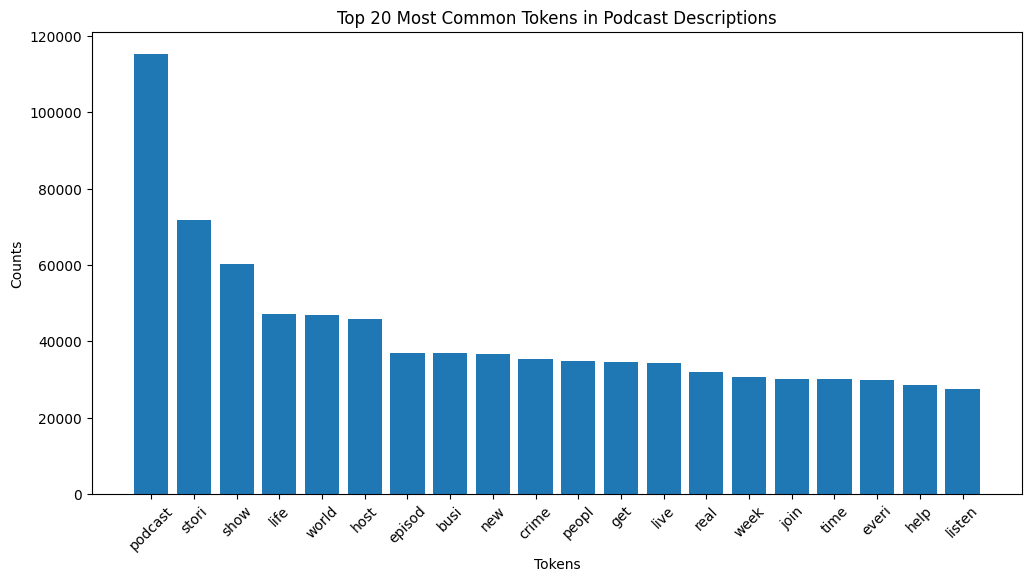

In [391]:
#printing top 20 tokens

most_common_tokens = num_unique_tokens.most_common(20)
tokens, counts = zip(*most_common_tokens)
plt.figure(figsize=(12, 6))
plt.bar(tokens, counts)
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Tokens in Podcast Descriptions')
plt.xlabel('Tokens')
plt.ylabel('Counts')
plt.savefig('../results/common_podcast_tokens.png')
plt.show()

### Tf-IDF Implementation

In [ ]:
#finding unique podcasts

unique_podcast = data.groupby('itunes_id').first().reset_index()
print('Total unique podcasts:', len(unique_podcast))

Total unique podcasts: 7206


In [ ]:
#only keeps unique token of each description

unique_podcast['unique_tokens'] = unique_podcast['tokens'].apply(lambda x: list(set(x)))

processed_texts = unique_podcast['unique_tokens'].apply(lambda x: ' '.join(x))
#compute tfidf for descriptions
tfidf_vectorizer = TfidfVectorizer(vocabulary=None, 
    max_features=5000,  
    min_df=5,          
    ngram_range=(1, 2) #consider singular token and bigram
)
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_texts)
print('TF-IDF matrix shape:', tfidf_matrix.shape)

TF-IDF matrix shape: (7206, 5000)


In [ ]:
#print the sorted top tfidf terms for a random user
feature_names = tfidf_vectorizer.get_feature_names_out()
row = tfidf_matrix[1].toarray()[0]

top_idx = np.argsort(row)[-10:][::-1]

print("\nTop 10 TF-IDF terms:")
for i in top_idx:
    print(feature_names[i], "→", round(row[i], 4))




Top 10 TF-IDF terms:
canon → 0.3328
lean → 0.3248
learn question → 0.3046
shoot → 0.3023
color → 0.2804
photographi → 0.2778
digit → 0.2317
side → 0.2312
matter → 0.2136
film → 0.2116


In [ ]:
#determine most popular terms in all
term_sums = np.array(tfidf_matrix.sum(axis=0)).flatten()
tfidf_df = pd.DataFrame({
    'term': feature_names,
    'tfidf_sum': term_sums
})
tfidf_df = tfidf_df.sort_values(by='tfidf_sum', ascending=False)

print(tfidf_df.head(20))

           term   tfidf_sum
3309    podcast  235.884435
2038       host  135.074245
3952       show  126.206051
1105    discuss  119.193796
4913      world  117.706946
4308       talk  113.121220
2522       life  110.294090
4164      stori  108.197188
2322       join  102.385795
2231  interview  102.224347
2599       live   95.682771
2983        new   93.662439
4794     weekli   93.455372
3206      peopl   91.153421
1326     episod   89.855057
4778       week   88.822871
1959       help   87.837010
1378      everi   86.510448
2577     listen   82.219330
1756        get   82.179459


In [ ]:
#get unique podcasts only
unique_podcast = (
    data.groupby('itunes_id').first().reset_index())

### Feature Item Matrix

In [ ]:
#feature item matrix generation

unique_categories = data['category'].unique()
#get unique category for each unique podcast
podcast_list = data.groupby('itunes_id')['category'].unique().reset_index()

#create a new list to include all categories for each podcast
unique_podcast = unique_podcast.merge(
    podcast_list,
    on='itunes_id',
    suffixes=('', '_all'),
    how='left'
)
#converts the categories into binary features of 0 or 1 
mlb = MultiLabelBinarizer()
categ_m = mlb.fit_transform(unique_podcast['category_all'])
print('Category feature matrix shape:', categ_m.shape)
categ_indx = {}
#creates a mapping from the category name to an index
for i, cat in enumerate(mlb.classes_):
    categ_indx[cat] = i

print('Total unique categories:', len(unique_categories))
print('Categories:', unique_categories)

Category feature matrix shape: (7206, 105)
Total unique categories: 105
Categories: ['arts' 'arts-performing-arts' 'music' 'arts-design' 'education'
 'society-culture' 'arts-books' 'arts-visual-arts' 'technology' 'leisure'
 'society-culture-personal-journals' 'society-culture-relationships'
 'fiction' 'fiction-science-fiction' 'arts-food'
 'education-language-learning' 'fiction-drama' 'true-crime'
 'health-fitness' 'health-fitness-nutrition' 'history' 'comedy'
 'arts-fashion-beauty' 'tv-film' 'comedy-comedy-interviews'
 'religion-spirituality' 'kids-family' 'tv-film-film-reviews'
 'leisure-games' 'society-culture-places-travel' 'leisure-hobbies'
 'society-culture-philosophy' 'spirituality' 'tv-film-film-history'
 'business' 'business-careers' 'business-entrepreneurship' 'science'
 'science-earth-sciences' 'health-fitness-sexuality' 'news'
 'news-politics' 'leisure-home-garden' 'leisure-video-games'
 'tv-film-tv-reviews' 'education-courses' 'fiction-comedy-fiction'
 'government' 'comedy

In [ ]:
#groups by the id and for the rating of each podcast it computed the mean and count
podcast_avg_rating = data.groupby('itunes_id')['rating'].agg(['mean', 'count']).reset_index()
#renaming the columns
podcast_avg_rating.columns = ['itunes_id', 'avg_rating', 'rating_count']
#merging it to the unique podcast data
unique_podcast = unique_podcast.merge(podcast_avg_rating, on='itunes_id', how='left')
podcast_avg_rating.head()


,itunes_id,avg_rating,rating_count
0,73329393,4.0,2
1,73329429,4.7,20
2,73329471,5.0,9
3,73329520,5.0,45
4,73329536,5.0,13


In [ ]:
#basic statistics of the rating and count
min_avg_rating = unique_podcast['avg_rating'].min()
max_avg_rating = unique_podcast['avg_rating'].max()
min_rating_count = unique_podcast['rating_count'].min()
max_rating_count = unique_podcast['rating_count'].max()
print("Minimum Average Rating: ", min_avg_rating)
print("Maximum Average Rating: ", max_avg_rating)
print("Minimum Rating Count: ", min_rating_count)
print("Maximum Rating Count: ", max_rating_count)

Minimum Average Rating:  1.0
Maximum Average Rating:  5.0
Minimum Rating Count:  1
Maximum Rating Count:  3975


In [ ]:
#groups and combines reviews for each podcast
podcast_reviews = data.groupby('itunes_id')['content'].apply(lambda x: ' '.join(x)).reset_index()
podcast_reviews.columns = ['itunes_id', 'all_reviews']
#apply datacleaning and tokenization fo each
podcast_reviews['all_reviews'] = podcast_reviews['all_reviews'].apply(clean_text)
podcast_reviews['all_reviews'] = podcast_reviews['all_reviews'].apply(tekonize_and_remove_stopwords)
#merge the tokens of the reviws with the podcasts data
unique_podcast = unique_podcast.merge(
    podcast_reviews[['itunes_id', 'all_reviews']],
    on='itunes_id',
    how='left'
)
print(podcast_reviews['all_reviews'].head())

0    [mark, johnson, easygo, pleasant, host, could,...
1    [avid, photograph, podcast, listen, tip, top, ...
2    [great, subject, interest, host, great, subjec...
3    [listen, guy, coupl, year, entertain, alway, c...
4    [awesomeawesomeawesom, meor, indiefe, altern, ...
Name: all_reviews, dtype: object


In [ ]:
#for each podcast it joins the reviews into one string
review_text = unique_podcast['all_reviews'].apply(lambda x: ' '.join(x))

#apply tfidf for review text
review_tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5)
review_tfidf_matrix = review_tfidf_vectorizer.fit_transform(review_text)
print('Review TF-IDF matrix shape:', review_tfidf_matrix.shape)

Review TF-IDF matrix shape: (7206, 5000)


In [ ]:
#added weights for each feature and changed to csr matrix for sparsity efficiency
desc_weighted = csr_matrix(tfidf_matrix) * 1   
cat_weighted =  csr_matrix(categ_m) * 0.6    
rev_weighted = csr_matrix(review_tfidf_matrix) * 0.3

item_feature_matrix = hstack([desc_weighted,
                              cat_weighted, 
                              rev_weighted])

#normalize each vector to prevent some from dominating others
item_feature_matrix = normalize(item_feature_matrix, norm='l2', axis=1)


### Statistics Analysis

In [ ]:
#number of ratings whicg where negative
neg_rating = data[data['rating'] <= 2]
total_rating = len(data)
print("Number of total ratings:", total_rating)
print("Number of negative ratings:", len(neg_rating))
print("Percentage of negative ratings: {:.2f}%".format(len(neg_rating) / total_rating * 100))


Number of total ratings: 195068
Number of negative ratings: 26108
Percentage of negative ratings: 13.38%


In [ ]:

#state for each user how many ratings where done
total_rating = data.groupby('author_id')['rating'].count()
#find for each user how many negative rating was done
neg_rating = data[data['rating'] <= 2].groupby('author_id')['rating'].count()

user_info = pd.DataFrame({
    'total_ratings': total_rating,
    'negative_ratings': neg_rating
})
#fill all missing with 0
user_info['negative_ratings'] = user_info['negative_ratings'].fillna(0)

#find percentage of negative ratings done by users
user_info['neg_ratio'] = user_info['negative_ratings'] / user_info['total_ratings']

#find users who at least 70% of ratings are negative
filered = user_info[user_info['neg_ratio'] >= 0.7]
print(f"Total users with >=70% negative ratings: {len(filered)} ({len(filered)/len(user_info)*100:.2f}%)")


Total users with >=70% negative ratings: 1737 (6.95%)


### User Profile + Cold Start Handling

In [ ]:
#users without cold start
def user_profile_no_cs(user, data, features, mapping):
    items_rated = data[data['author_id'] == user] #find rows/items where the user rated only
    if len(items_rated) == 0:
        return None #if no rating given return none
    user_profile_vector = np.zeros(features.shape[1]) #create a vector similar to feature matrix
    weights_sum = 0
    for _, row in items_rated.iterrows(): #for each item
        podcast = row['itunes_id'] #get id
        rat = row['rating'] #get rating
        podcast_idx = mapping[mapping['itunes_id'] == podcast].index[0] #get feature vector for the podcast
        podcast_features = features[podcast_idx].toarray().flatten()
        user_profile_vector += rat * podcast_features #multiply rating to feature vector
        weights_sum += abs(rat) #for normalization
    user_profile_vector = user_profile_vector/ weights_sum #compute user profile for all items
    return user_profile_vector


In [ ]:
#for cold start users
def user_profile_cd(features, mapping, pop, top=20):
    top_pod = pd.Series(pop).head(top).values #take popular podcasts
    user_profile_vector = np.zeros(features.shape[1]) #create vector
    weights_sum = 0
    for podcast in top_pod:
        podcast_idx = mapping[mapping['itunes_id'] == podcast].index[0] #find index for its mapping
        podcast_features = features[podcast_idx].toarray().flatten() #get feature vector of the item
        user_profile_vector += podcast_features #all popular get weighted equally and added together
        weights_sum += 1
    if weights_sum > 0:
        user_profile_vector = user_profile_vector/ weights_sum #compute according to average of popular items.
    return user_profile_vector


In [389]:
def user_profile(user, data, features, mapping, pop, thresh=3, top=20):
    items_rated = data[data['author_id'] == user] #find ratings of user
    neg_rating = (items_rated['rating'] <= 2).sum() #find negative number of ratings
    total = neg_rating/len(items_rated) #find overall negative ration
    if len(items_rated) < thresh or (total >= 0.85): #if user with mostly negative ratings or low then use cold start method
        return user_profile_cd(features, mapping, pop, top)

    else: #otherwise use normal computation for user profile
        return user_profile_no_cs(user, data, features, mapping)

### Content-Based Recommendation

In [ ]:
def recommend_podcasts(user_id,user_profile, features, mapping, already_rated,top_n=[10,20]):

    #change to 2D array
    if len(user_profile.shape) == 1:
        user_profile = user_profile.reshape(1, -1)

    #find cosine similarity between the user profile and the podcasts in item feature matrix
    sim = cosine_similarity(user_profile, features).flatten()

    #remove already rated items and gave it a similarity of -1
    for podcast in already_rated:
        podcast_id = mapping[mapping['itunes_id'] == podcast].index[0]
        sim[podcast_id] = -1

    #loops for n
    r = {}
    for n in top_n:

        #sort the similarities from highest to lowest and choose top n
        top_pod = sim.argsort()[::-1][:n]
        recommendations = []
        #go through each top podcast and get metadata about it
        for rank, i in enumerate(top_pod, 1):
            details = mapping.iloc[i]
            recommendations.append({
                'rank': rank,
                'user_id': user_id,
                'itunes_id': details['itunes_id'],
                'title': details['title_y'],
                'category': details['category_all'],
                'avg_rating': round(details['avg_rating'], 2),
                'rating_count': details['rating_count'],
                'similarity_score_cb': round(sim[i], 4)
            })
        #save the dataframe into dictionary
        r[f'top_{n}'] = pd.DataFrame(recommendations)
    return r

In [ ]:
#create table for unique podcast and their metadata
podcast_mapping = (
    unique_podcast
    .drop_duplicates('itunes_id')
    [['itunes_id', 'title_y', 'category_all', 'avg_rating', 'rating_count']]
    .reset_index(drop=True)
)
#find popular podcasts by grouping podcasts and counting rows in each group
popular_podcasts = data.groupby('itunes_id').size().sort_values(ascending=False).index

all_recom10 = []
all_recom20 = []

unique_users = data['author_id'].unique()
for id, user in enumerate(unique_users):
    #for each user generate user profile
    user_prof = user_profile(user, data, item_feature_matrix, 
                        podcast_mapping, popular_podcasts, thresh=2, top=20)
    #find rated items and recommends top 10 and 20.
    if user_prof is not None:
        already_rated = data[data['author_id'] == user]['itunes_id'].tolist()
        recs = recommend_podcasts(user,user_prof, item_feature_matrix, podcast_mapping,
                             already_rated, top_n=[10,20])
        
        all_recom10.append(recs['top_10'])
        all_recom20.append(recs['top_20'])
        

final_recom1 = pd.concat(all_recom10, ignore_index=True)
final_recom2 = pd.concat(all_recom20, ignore_index=True)    

In [ ]:
#table for top 10 recommendation 
final_recom1

,rank,user_id,itunes_id,title,category,avg_rating,rating_count,similarity_score_cb
0,1,F6BF5472689BD12,1448624686,BIG EGO Tapes,"[arts, arts-performing-arts, music]",5.00,3,0.5582
1,2,F6BF5472689BD12,1359506595,Van Sessions,"[arts, arts-performing-arts, music]",5.00,6,0.5475
2,3,F6BF5472689BD12,1463123147,Talks With John Podcast,"[arts, arts-performing-arts, music]",5.00,3,0.5421
3,4,F6BF5472689BD12,176922857,Oklahoma State University Percussion Podcast,"[arts, arts-performing-arts, music]",3.00,3,0.5385
4,5,F6BF5472689BD12,1123364603,CHUCK SCHADEN'S MEMORY LANE,"[arts, arts-performing-arts, music]",5.00,6,0.5371
...,...,...,...,...,...,...,...,...
249995,6,B9D17F18C525E39,1325443181,In Retrospect,"[kids-family, society-culture]",5.00,2,0.4185
249996,7,B9D17F18C525E39,1463633703,OHoney with Amanda Cerny & Sommer Ray,"[comedy, society-culture]",3.17,12,0.4142
249997,8,B9D17F18C525E39,795782888,Bad Parenting Podcast,"[comedy, kids-family]",5.00,2,0.4090
249998,9,B9D17F18C525E39,1299573980,Table Talk with Rookie's Family,"[kids-family, society-culture]",2.67,6,0.4078


In [ ]:
#table for top 20 recommendation 

final_recom2

,rank,user_id,itunes_id,title,category,avg_rating,rating_count,similarity_score_cb
0,1,F6BF5472689BD12,1448624686,BIG EGO Tapes,"[arts, arts-performing-arts, music]",5.00,3,0.5582
1,2,F6BF5472689BD12,1359506595,Van Sessions,"[arts, arts-performing-arts, music]",5.00,6,0.5475
2,3,F6BF5472689BD12,1463123147,Talks With John Podcast,"[arts, arts-performing-arts, music]",5.00,3,0.5421
3,4,F6BF5472689BD12,176922857,Oklahoma State University Percussion Podcast,"[arts, arts-performing-arts, music]",3.00,3,0.5385
4,5,F6BF5472689BD12,1123364603,CHUCK SCHADEN'S MEMORY LANE,"[arts, arts-performing-arts, music]",5.00,6,0.5371
...,...,...,...,...,...,...,...,...
499995,16,B9D17F18C525E39,1210253100,Dem Black Mamas Podcast,"[kids-family, society-culture]",5.00,2,0.3914
499996,17,B9D17F18C525E39,866402473,North and South by Elizabeth Gaskell,"[kids-family, society-culture]",2.00,2,0.3913
499997,18,B9D17F18C525E39,1248528858,Parenting Then and Now,"[kids-family, society-culture, society-culture...",5.00,3,0.3911
499998,19,B9D17F18C525E39,1092361338,Las Culturistas with Matt Rogers and Bowen Yang,"[comedy, society-culture]",4.86,208,0.3886


In [ ]:
#example for user recommendation (top 10)
sample_user = final_recom1['user_id'].iloc[0]
final_recom1[final_recom1['user_id'] == sample_user]

,rank,user_id,itunes_id,title,category,avg_rating,rating_count,similarity_score_cb
0,1,F6BF5472689BD12,1448624686,BIG EGO Tapes,"[arts, arts-performing-arts, music]",5.0,3,0.5582
1,2,F6BF5472689BD12,1359506595,Van Sessions,"[arts, arts-performing-arts, music]",5.0,6,0.5475
2,3,F6BF5472689BD12,1463123147,Talks With John Podcast,"[arts, arts-performing-arts, music]",5.0,3,0.5421
3,4,F6BF5472689BD12,176922857,Oklahoma State University Percussion Podcast,"[arts, arts-performing-arts, music]",3.0,3,0.5385
4,5,F6BF5472689BD12,1123364603,CHUCK SCHADEN'S MEMORY LANE,"[arts, arts-performing-arts, music]",5.0,6,0.5371
5,6,F6BF5472689BD12,1279948908,Petticoat Rule,"[arts, arts-performing-arts, music]",5.0,3,0.5366
6,7,F6BF5472689BD12,211525170,Radio Bastet - Vintage Belly Dance Music,"[arts, arts-performing-arts, music]",5.0,3,0.5357
7,8,F6BF5472689BD12,797430375,DEEP HOUSE LOUNGE - EXCLUSIVE DEEP HOUSE MUSIC...,"[arts, arts-performing-arts, music]",5.0,3,0.5307
8,9,F6BF5472689BD12,1151249001,That One Song,"[arts, arts-performing-arts, music]",5.0,6,0.5299
9,10,F6BF5472689BD12,1094393194,Inside The West End Podcast,"[arts, arts-performing-arts, music]",5.0,3,0.5296


In [392]:
sample_user = final_recom1['user_id'].iloc[100]
final_recom1[final_recom1['user_id'] == sample_user]

,rank,user_id,itunes_id,title,category,avg_rating,rating_count,similarity_score_cb
100,1,A498E6EA7B5F9C3,384235267,Entitled Opinions (about Life and Literature),"[society-culture, society-culture-philosophy]",4.00,4,0.6484
101,2,A498E6EA7B5F9C3,942242075,ONDEM Podcasts,"[society-culture, society-culture-philosophy, ...",5.00,3,0.5797
102,3,A498E6EA7B5F9C3,659155419,Philosophize This!,"[education, society-culture, society-culture-p...",4.61,192,0.5687
103,4,A498E6EA7B5F9C3,1324082896,"THINK BIGGER, THINK BETTER","[science, science-social-sciences, society-cul...",5.00,8,0.5617
104,5,A498E6EA7B5F9C3,206817194,WDR ZeitZeichen,[society-culture],5.00,1,0.5608
105,6,A498E6EA7B5F9C3,1377848391,On Wisdom,"[science, science-social-sciences, society-cul...",5.00,4,0.5534
106,7,A498E6EA7B5F9C3,1304361213,General Intellect Unit,"[education, society-culture, society-culture-p...",5.00,3,0.5436
107,8,A498E6EA7B5F9C3,847581558,Blog - Space Time Mind,"[society-culture, society-culture-philosophy]",5.00,4,0.5364
108,9,A498E6EA7B5F9C3,327041563,Animal Rights: The Abolitionist Approach Comme...,"[education, society-culture, society-culture-p...",3.67,9,0.5351
109,10,A498E6EA7B5F9C3,706518211,Expanded Perspectives,"[science, society-culture, society-culture-phi...",4.55,240,0.5243


In [ ]:
final_recom1.to_csv('../data/cb_data.csv', index=False)
final_recom2.to_csv('../data/cb_data2.csv', index=False)

In [350]:
print("Similarity Scores\n", final_recom1['similarity_score_cb'].describe())


Similarity Scores
 count    250000.000000
mean          0.470371
std           0.066895
min           0.217200
25%           0.427200
50%           0.472400
75%           0.513600
max           0.976000
Name: similarity_score_cb, dtype: float64


In [351]:
print("Similarity Scores\n", final_recom2['similarity_score_cb'].describe())


Similarity Scores
 count    500000.000000
mean          0.448112
std           0.067479
min           0.160500
25%           0.406000
50%           0.447300
75%           0.487400
max           0.976000
Name: similarity_score_cb, dtype: float64


In [352]:
print("Avergae rating count final_recom1\n", final_recom1['rating_count'].mean())
print("Median rating count final_recom1\n", final_recom1['rating_count'].median())

Avergae rating count final_recom1
 189.636044
Median rating count final_recom1
 20.0


In [353]:
print("Avergae rating count final_recom2\n", final_recom2['rating_count'].mean())
print("Median rating count final_recom2\n", final_recom2['rating_count'].median())

Avergae rating count final_recom2
 159.637152
Median rating count final_recom2
 16.0


### KNN Implementation

In [ ]:
def knn(user, target, data, mapping, all_distances, all_indices, 
                  unique_podcast, n_neighbors=10):
    #ratings done by user
    user_rating = data[data['author_id'] == user]
    if len(user_rating) == 0:
        return None
    

    #index of podcast in feature matrix 
    target_idx = mapping[mapping['itunes_id'] == target].index[0]

    #index of nearest neighbors
    neighbors_index = all_indices[target_idx][1:n_neighbors+1]

    #distance of nearest neighbors
    neighbors_distances = all_distances[target_idx][1:n_neighbors+1]

    #find sim
    sim = 1 - neighbors_distances
    neigh = []
    sim_sum = 0
    w_sum= 0

    #for each neighbor get its details and check if its rated to find weighted sum.
    for index, similarity in zip(neighbors_index, sim):
        podcast_id = mapping.iloc[index]['itunes_id']
        details = unique_podcast[unique_podcast['itunes_id'] == podcast_id].iloc[0]

        rating = user_rating[user_rating['itunes_id'] == podcast_id]['rating']

        if not rating.empty:
            w_sum += similarity*rating.values[0]
            sim_sum += similarity

        neighbor_info = {
            'itunes_id': podcast_id,
            'title': details['title_y'],
            'category': details['category'],
            'avg_rating': details['avg_rating'].round(2),
            'rating_count': details['rating_count'],
            'similarity': round(similarity, 2),
            'user_rated': not rating.empty,
            'user_rating': rating.values[0] if not rating.empty else None
        }
        neigh.append(neighbor_info)
    #if user has rated neighbor then find prediction
    if sim_sum > 0:
        predicted_rating = w_sum / sim_sum
        method = "Weighted k-NN"
    #if not rated then use average rating of item
    else:
        predicted_rating = unique_podcast[
            unique_podcast['itunes_id'] == target
        ]['avg_rating'].values[0]
        method = "Fallback: item average"
    #add extra attributes
    r = pd.DataFrame(neigh)
    r.attrs['predicted_rating'] = round(predicted_rating, 2)
    r.attrs['method'] = method
    r.attrs['rated_neighbors'] = sim_sum > 0
    r.attrs['target_podcast'] = target
    return r

In [ ]:
all_knn_results = {10: [], 20: []}
all_items = podcast_mapping['itunes_id'].tolist()

k_values = [10, 20]
#apply knn for each value of k using cosine
for k in k_values:
    print("K = ", k)
    knn_model = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    knn_model.fit(item_feature_matrix)
    #get the distance and index of each neighbor
    distances, indices = knn_model.kneighbors(item_feature_matrix, n_neighbors=k+1)
    
    for user in tqdm(unique_users, desc=f"Processing users (k={k})"):
        user_info = data[data['author_id'] == user]

        if user_info.empty:
            continue
        #for each user find the not rated items and get top 20 recommendations for the user
        rated = set(data[data['author_id'] == user]['itunes_id'])
        not_rated = set(all_items) - rated
        user_recs = final_recom1[final_recom1['user_id'] == user].head(20)
        candidates = user_recs['itunes_id'].tolist()
        #find recommended podcasts that wasnt rated
        items_to_predict = set(candidates) & not_rated

        #for each podcast not rated apply knn
        for target in items_to_predict:
            r = knn(
                    user=user,
                    target=target,
                    data=data,
                    mapping=podcast_mapping,
                    all_distances=distances,
                    all_indices=indices,
                    unique_podcast=unique_podcast,
                    n_neighbors=k
                )
            if r is None:
                continue

            all_knn_results[k].append({
                "user_id": user,
                "itunes_id": target,
                "predicted_rating": r.attrs['predicted_rating'],
                "method": r.attrs['method'],
                "rated_neighbors": r.attrs['rated_neighbors'],
                "k_value": k
            })
    
    print(f"\nCompleted predictions for k={k}: {len(all_knn_results[k]):,} predictions")


K =  10


Processing users (k=10): 100%|██████████| 25000/25000 [1:28:13<00:00,  4.72it/s]  



Completed predictions for k=10: 250,000 predictions
K =  20


Processing users (k=20): 100%|██████████| 25000/25000 [1:41:03<00:00,  4.12it/s]  


Completed predictions for k=20: 250,000 predictions


### Results Comparison

KNN (K=10)

In [357]:
knn_10 = pd.DataFrame(all_knn_results[10])
knn_20 = pd.DataFrame(all_knn_results[20])

In [372]:
knn_10

,user_id,itunes_id,predicted_rating,method,rated_neighbors,k_value
0,F6BF5472689BD12,1359506595,5.0,Weighted k-NN,True,10
1,F6BF5472689BD12,797430375,5.0,Weighted k-NN,True,10
2,F6BF5472689BD12,1151249001,5.0,Weighted k-NN,True,10
3,F6BF5472689BD12,176922857,5.0,Weighted k-NN,True,10
4,F6BF5472689BD12,1463123147,5.0,Weighted k-NN,True,10
...,...,...,...,...,...,...
249995,B9D17F18C525E39,1445499503,5.0,Weighted k-NN,True,10
249996,B9D17F18C525E39,1319028144,5.0,Weighted k-NN,True,10
249997,B9D17F18C525E39,871635282,5.0,Weighted k-NN,True,10
249998,B9D17F18C525E39,1460349398,5.0,Fallback: item average,False,10


In [358]:
print(f"Total predictions: {len(knn_10):,}")
print(f"Unique users covered: {knn_10['user_id'].nunique():,}")
print(f"Unique items predicted: {knn_10['itunes_id'].nunique():,}")
print(f"Avg predictions per user: {knn_10.groupby('user_id').size().mean():.2f}")

Total predictions: 250,000
Unique users covered: 25,000
Unique items predicted: 6,328
Avg predictions per user: 10.00


In [361]:
knn_10.describe().round(2)

,itunes_id,predicted_rating,k_value
count,2.500000e+05,250000.00,250000.0
mean,1.093376e+09,4.60,10.0
std,3.733149e+08,0.74,0.0
min,7.332939e+07,1.00,10.0
25%,9.789803e+08,4.44,10.0
50%,1.204570e+09,5.00,10.0
75%,1.375323e+09,5.00,10.0
max,1.470955e+09,5.00,10.0


In [371]:
print(knn_10['method'].value_counts())


method
Weighted k-NN             128826
Fallback: item average    121174
Name: count, dtype: int64


In [359]:
print(f"Total predictions: {len(knn_20):,}")
print(f"Unique users covered: {knn_20['user_id'].nunique():,}")
print(f"Unique items predicted: {knn_20['itunes_id'].nunique():,}")
print(f"Avg predictions per user: {knn_20.groupby('user_id').size().mean():.2f}")


Total predictions: 250,000
Unique users covered: 25,000
Unique items predicted: 6,328
Avg predictions per user: 10.00


In [387]:
def neighbor_consistency_simple(knn_results, data, distances, indices, podcast_mapping, n_neighbors=20, max_users=2000):
    results = []

    users = data['author_id'].unique()[:max_users]
    for user in tqdm(users, desc="Users"):
        user_ratings = data[data['author_id'] == user]
        user_recs = knn_results[(knn_results['user_id'] == user) & 
                                (knn_results['method'] == 'Weighted k-NN')]
        if user_recs.empty:
            continue

        for _, rec in user_recs.iterrows():
            target = rec['itunes_id']

            target_idx = podcast_mapping[podcast_mapping['itunes_id'] == target].index
            if len(target_idx) == 0:
                continue

            neighbor_idx = indices[target_idx[0]][1:n_neighbors+1]
            neighbor_rated_count = sum(
                not user_ratings[user_ratings['itunes_id'] == podcast_mapping.iloc[idx]['itunes_id']]['rating'].empty
                for idx in neighbor_idx
            )
            results.append({
                'user': user,
                'target': target,
                'n_neighbors_rated': neighbor_rated_count
            })

    return pd.DataFrame(results)
consistency_df = neighbor_consistency_simple(knn_10, data, distances, indices, podcast_mapping)
print(consistency_df['n_neighbors_rated'].value_counts().sort_index())


Users: 100%|██████████| 2000/2000 [02:02<00:00, 16.33it/s]


n_neighbors_rated
1    8194
2    1595
3     322
4      94
5      14
6       9
7       5
8       2
Name: count, dtype: int64


KNN (K=20)

In [373]:
knn_20

,user_id,itunes_id,predicted_rating,method,rated_neighbors,k_value
0,F6BF5472689BD12,1359506595,5.0,Weighted k-NN,True,20
1,F6BF5472689BD12,797430375,5.0,Weighted k-NN,True,20
2,F6BF5472689BD12,1151249001,5.0,Weighted k-NN,True,20
3,F6BF5472689BD12,176922857,5.0,Weighted k-NN,True,20
4,F6BF5472689BD12,1463123147,5.0,Weighted k-NN,True,20
...,...,...,...,...,...,...
249995,B9D17F18C525E39,1445499503,5.0,Weighted k-NN,True,20
249996,B9D17F18C525E39,1319028144,5.0,Weighted k-NN,True,20
249997,B9D17F18C525E39,871635282,5.0,Weighted k-NN,True,20
249998,B9D17F18C525E39,1460349398,5.0,Weighted k-NN,True,20


In [362]:
knn_20.describe().round(2)

,itunes_id,predicted_rating,k_value
count,2.500000e+05,250000.00,250000.0
mean,1.093376e+09,4.63,20.0
std,3.733149e+08,0.74,0.0
min,7.332939e+07,1.00,20.0
25%,9.789803e+08,4.72,20.0
50%,1.204570e+09,5.00,20.0
75%,1.375323e+09,5.00,20.0
max,1.470955e+09,5.00,20.0


In [370]:
print(knn_20['method'].value_counts())


method
Weighted k-NN             163082
Fallback: item average     86918
Name: count, dtype: int64


In [ ]:
knn_10.to_csv('../data/cb_data_rating_pred1.csv', index=False)
knn_20.to_csv('../data/cb_data_rating_pred2.csv', index=False)


In [379]:
consistency_df = neighbor_consistency_simple(knn_20, data, distances, indices, podcast_mapping)
print(consistency_df['n_neighbors_rated'].value_counts().sort_index())

Users: 100%|██████████| 2000/2000 [02:18<00:00, 14.48it/s]

n_neighbors_rated
1    10730
2     1760
3      339
4       96
5       14
6       10
7        5
8        2
Name: count, dtype: int64


In [ ]:
#reference for numerical example
target_user = "00003779EB0FA1F"
user_prof = user_profile(
    target_user,
    data,
    item_feature_matrix,
    podcast_mapping,
    popular_podcasts,
    thresh=2,
    top=20
)

user_norm = np.linalg.norm(user_prof)
print(f"user: {target_user}")
selected_titles = [
    "halloween",
    "why we drink",
    "favorite murder"
]
selected_items = podcast_mapping[
    podcast_mapping["title_y"]
    .str.lower()
    .str.contains("|".join(selected_titles))
]
for _, row in selected_items.iterrows():
    itunes_id = row["itunes_id"]
    title = row["title_y"]

    item_idx = podcast_mapping[podcast_mapping["itunes_id"] == itunes_id].index[0]
    item_vector = item_feature_matrix[item_idx].toarray().flatten()

    item_norm = np.linalg.norm(item_vector)
    dot_product = np.dot(user_prof, item_vector)
    denominator = user_norm * item_norm
    similarity = dot_product / denominator if denominator > 0 else 0

    non_zero_idx = np.where(item_vector > 0)[0]
    top_features = non_zero_idx[np.argsort(item_vector[non_zero_idx])[-10:][::-1]]

    print(f"\nItem: {title}")
    print(f"  iTunes ID: {itunes_id}")

    print(f"\n  Top {10} TF-IDF Features:")
    for idx in top_features:
        print(f"    Feature[{idx}] = {item_vector[idx]:.4f}")

    print(f"\n  Cosine Similarity Calculation:")
    print(f"    Dot Product = {dot_product:.4f}")
    print(f"    Denominator = {user_norm:.4f} × {item_norm:.4f} = {denominator:.4f}")
    print(f"    SIMILARITY = {similarity:.4f}")


user: 00003779EB0FA1F

Item: The Halloween Haunt
  iTunes ID: 201083805

  Top 10 TF-IDF Features:
    Feature[5041] = 0.4983
    Feature[4108] = 0.2662
    Feature[3234] = 0.2662
    Feature[1915] = 0.2320
    Feature[948] = 0.2163
    Feature[1586] = 0.2141
    Feature[3233] = 0.2134
    Feature[4524] = 0.2077
    Feature[3048] = 0.1945
    Feature[968] = 0.1941

  Cosine Similarity Calculation:
    Dot Product = 0.0899
    Denominator = 0.3991 × 1.0000 = 0.3991
    SIMILARITY = 0.2252

Item: My Favorite Murder with Karen Kilgariff and Georgia Hardstark
  iTunes ID: 1074507850

  Top 10 TF-IDF Features:
    Feature[5098] = 0.4460
    Feature[5016] = 0.4460
    Feature[1944] = 0.2625
    Feature[2020] = 0.2526
    Feature[2372] = 0.2474
    Feature[1754] = 0.2352
    Feature[2550] = 0.2171
    Feature[2916] = 0.2053
    Feature[911] = 0.1820
    Feature[4306] = 0.1813

  Cosine Similarity Calculation:
    Dot Product = 0.2076
    Denominator = 0.3991 × 1.0000 = 0.3991
    SIMILARITY =